In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
cd /content/drive/MyDrive/Irgos_challenege2022

/content/drive/MyDrive/Irgos_challenege2022


In [ ]:
!unzip /content/drive/MyDrive/Irgos_challenege2022/airogs-example-algorithm-master.zip

Archive:  /content/drive/MyDrive/Irgos_challenege2022/airogs-example-algorithm-master.zip
   creating: airogs-example-algorithm-master/
 extracting: airogs-example-algorithm-master/.gitattributes  
  inflating: airogs-example-algorithm-master/.gitignore  
  inflating: airogs-example-algorithm-master/2dmodelairgos.pth  
 extracting: airogs-example-algorithm-master/build.bat  
  inflating: airogs-example-algorithm-master/build.sh  
  inflating: airogs-example-algorithm-master/Dockerfile  
  inflating: airogs-example-algorithm-master/export.bat  
  inflating: airogs-example-algorithm-master/export.sh  
  inflating: airogs-example-algorithm-master/irgos_2d2.py  
   creating: airogs-example-algorithm-master/output/
   creating: airogs-example-algorithm-master/output1/
  inflating: airogs-example-algorithm-master/output/multiple-referable-glaucoma-binary.json  
  inflating: airogs-example-algorithm-master/output/multiple-referable-glaucoma-likelihoods.json  
  inflating: airogs-example-algor

In [ ]:
!pip install timm
!pip install evalutils

     |████████████████████████████████| 431 kB 4.3 MB/s 
     |████████████████████████████████| 558 kB 4.3 MB/s 
     |████████████████████████████████| 48.4 MB 18 kB/s 
     |████████████████████████████████| 64 kB 2.1 MB/s 


In [ ]:
!pip install imagecodecs==2021.11.20

     |████████████████████████████████| 31.0 MB 1.4 MB/s 


In [ ]:
!pip install tifffile==2021.8.8

     |████████████████████████████████| 171 kB 4.0 MB/s 
  Attempting uninstall: tifffile
    Found existing installation: tifffile 2021.11.2
    Uninstalling tifffile-2021.11.2:
      Successfully uninstalled tifffile-2021.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from traitlets.traitlets import Bool
from typing import Dict

import SimpleITK
import tqdm
import json
from pathlib import Path
import tifffile
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
path='/content/drive/MyDrive/Irgos_challenege2022/airogs-example-algorithm-master/2dmodelairgos.pth'

########### define model object for prediction ########
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_, DropPath
from timm.models.registry import register_model

class Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), 
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, num_classes=1000, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0., 
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 ):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j], 
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        out=x
        #print(x1.shape)
        x = self.head(x)
        return x,out

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first. 
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with 
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs 
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


model_urls = {
    "convnext_tiny_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth",
    "convnext_small_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_small_1k_224_ema.pth",
    "convnext_base_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth",
    "convnext_large_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_1k_224_ema.pth",
    "convnext_base_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_224.pth",
    "convnext_large_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth",
    "convnext_xlarge_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_xlarge_22k_224.pth",
}

@register_model
def convnext_tiny(pretrained=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], **kwargs)
    if pretrained:
        url = model_urls['convnext_tiny_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu", check_hash=True)
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_small(pretrained=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[96, 192, 384, 768], **kwargs)
    if pretrained:
        url = model_urls['convnext_small_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_base(pretrained=False, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], **kwargs)
    if pretrained:
        url = model_urls['convnext_base_22k'] if in_22k else model_urls['convnext_base_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_large(pretrained=False, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[192, 384, 768, 1536], **kwargs)
    if pretrained:
        url = model_urls['convnext_large_22k'] if in_22k else model_urls['convnext_large_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_xlarge(pretrained=False, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[256, 512, 1024, 2048], **kwargs)
    if pretrained:
        assert in_22k, "only ImageNet-22K pre-trained ConvNeXt-XL is available; please set in_22k=True"
        url = model_urls['convnext_xlarge_22k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model
import sys 
import os
import glob
import time
import random
import os
import glob
import time
import random
import torch
import numpy as np
import pandas as pd
import torch.nn as nn


class CFG:
    img_size = 256
    n_frames = 10
    
    cnn_features = 256
    lstm_hidden = 32
    
    n_fold = 5
    n_epochs = 15
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        #self.map = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1)
        self.net =convnext_base(pretrained=False)
        #checkpoint = torch.load("../input/efficientnet-pytorch/efficientnet-b0-08094119.pth")
        #self.net.load_state_dict(checkpoint)
        #out = out.view(-1, self.in_planes)
        self.net.head = nn.Linear(in_features=1024, out_features=2, bias=True)
    
    def forward(self, x):
        #x = F.relu(self.map(x))
        out,out1 = self.net(x)
        return out,out1
    
model=CNN()



################### variational autoencoder model
import numpy as np
import torch
import torch.distributions as dist

#from example_algos.models.nets import BasicEncoder, BasicGenerator

import warnings

import numpy as np
import torch
import torch.nn as nn


class NoOp(nn.Module):
    def __init__(self, *args, **kwargs):
        """NoOp Pytorch Module.
        Forwards the given input as is.
        """
        super(NoOp, self).__init__()

    def forward(self, x, *args, **kwargs):
        return x


class ConvModule(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        conv_op=nn.Conv2d,
        conv_params=None,
        normalization_op=None,
        normalization_params=None,
        activation_op=nn.LeakyReLU,
        activation_params=None,
    ):
        """Basic Conv Pytorch Conv Module
        Has can have a Conv Op, a Normlization Op and a Non Linearity:
        x = conv(x)
        x = some_norm(x)
        x = nonlin(x)

        Args:
            in_channels ([int]): [Number on input channels/ feature maps]
            out_channels ([int]): [Number of ouput channels/ feature maps]
            conv_op ([torch.nn.Module], optional): [Conv operation]. Defaults to nn.Conv2d.
            conv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to None.
            normalization_op ([torch.nn.Module], optional): [Normalization Operation (e.g. BatchNorm, InstanceNorm,...)]. Defaults to None.
            normalization_params ([dict], optional): [Init parameters for the normalization operation]. Defaults to None.
            activation_op ([torch.nn.Module], optional): [Actiovation Operation/ Non-linearity (e.g. ReLU, Sigmoid,...)]. Defaults to nn.LeakyReLU.
            activation_params ([dict], optional): [Init parameters for the activation operation]. Defaults to None.
        """

        super(ConvModule, self).__init__()

        self.conv_params = conv_params
        if self.conv_params is None:
            self.conv_params = {}
        self.activation_params = activation_params
        if self.activation_params is None:
            self.activation_params = {}
        self.normalization_params = normalization_params
        if self.normalization_params is None:
            self.normalization_params = {}

        self.conv = None
        if conv_op is not None and not isinstance(conv_op, str):
            self.conv = conv_op(in_channels, out_channels, **self.conv_params)

        self.normalization = None
        if normalization_op is not None and not isinstance(normalization_op, str):
            self.normalization = normalization_op(out_channels, **self.normalization_params)

        self.activation = None
        if activation_op is not None and not isinstance(activation_op, str):
            self.activation = activation_op(**self.activation_params)

    def forward(self, input, conv_add_input=None, normalization_add_input=None, activation_add_input=None):

        x = input

        if self.conv is not None:
            if conv_add_input is None:
                x = self.conv(x)
            else:
                x = self.conv(x, **conv_add_input)

        if self.normalization is not None:
            if normalization_add_input is None:
                x = self.normalization(x)
            else:
                x = self.normalization(x, **normalization_add_input)

        if self.activation is not None:
            if activation_add_input is None:
                x = self.activation(x)
            else:
                x = self.activation(x, **activation_add_input)

        # nn.functional.dropout(x, p=0.95, training=True)

        return x


class ConvBlock(nn.Module):
    def __init__(
        self,
        n_convs: int,
        n_featmaps: int,
        conv_op=nn.Conv2d,
        conv_params=None,
        normalization_op=nn.BatchNorm2d,
        normalization_params=None,
        activation_op=nn.LeakyReLU,
        activation_params=None,
    ):
        """Basic Conv block with repeated conv, build up from repeated @ConvModules (with same/fixed feature map size)

        Args:
            n_convs ([type]): [Number of convolutions]
            n_featmaps ([type]): [Feature map size of the conv]
            conv_op ([torch.nn.Module], optional): [Convulioton operation -> see ConvModule ]. Defaults to nn.Conv2d.
            conv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to None.
            normalization_op ([torch.nn.Module], optional): [Normalization Operation (e.g. BatchNorm, InstanceNorm,...) -> see ConvModule]. Defaults to nn.BatchNorm2d.
            normalization_params ([dict], optional): [Init parameters for the normalization operation]. Defaults to None.
            activation_op ([torch.nn.Module], optional): [Actiovation Operation/ Non-linearity (e.g. ReLU, Sigmoid,...) -> see ConvModule]. Defaults to nn.LeakyReLU.
            activation_params ([dict], optional): [Init parameters for the activation operation]. Defaults to None.
        """

        super(ConvBlock, self).__init__()

        self.n_featmaps = n_featmaps
        self.n_convs = n_convs
        self.conv_params = conv_params
        if self.conv_params is None:
            self.conv_params = {}

        self.conv_list = nn.ModuleList()

        for i in range(self.n_convs):
            conv_layer = ConvModule(
                n_featmaps,
                n_featmaps,
                conv_op=conv_op,
                conv_params=conv_params,
                normalization_op=normalization_op,
                normalization_params=normalization_params,
                activation_op=activation_op,
                activation_params=activation_params,
            )
            self.conv_list.append(conv_layer)

    def forward(self, input, **frwd_params):
        x = input
        for conv_layer in self.conv_list:
            x = conv_layer(x)

        return x


class ResBlock(nn.Module):
    def __init__(
        self,
        n_convs,
        n_featmaps,
        conv_op=nn.Conv2d,
        conv_params=None,
        normalization_op=nn.BatchNorm2d,
        normalization_params=None,
        activation_op=nn.LeakyReLU,
        activation_params=None,
    ):
        """Basic Conv block with repeated conv, build up from repeated @ConvModules (with same/fixed feature map size) and a skip/ residual connection:
        x = input
        x = conv_block(x)
        out = x + input

        Args:
            n_convs ([type]): [Number of convolutions in the conv block]
            n_featmaps ([type]): [Feature map size of the conv block]
            conv_op ([torch.nn.Module], optional): [Convulioton operation -> see ConvModule ]. Defaults to nn.Conv2d.
            conv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to None.
            normalization_op ([torch.nn.Module], optional): [Normalization Operation (e.g. BatchNorm, InstanceNorm,...) -> see ConvModule]. Defaults to nn.BatchNorm2d.
            normalization_params ([dict], optional): [Init parameters for the normalization operation]. Defaults to None.
            activation_op ([torch.nn.Module], optional): [Actiovation Operation/ Non-linearity (e.g. ReLU, Sigmoid,...) -> see ConvModule]. Defaults to nn.LeakyReLU.
            activation_params ([dict], optional): [Init parameters for the activation operation]. Defaults to None.
        """
        super(ResBlock, self).__init__()

        self.n_featmaps = n_featmaps
        self.n_convs = n_convs
        self.conv_params = conv_params
        if self.conv_params is None:
            self.conv_params = {}

        self.conv_block = ConvBlock(
            n_featmaps,
            n_convs,
            conv_op=conv_op,
            conv_params=conv_params,
            normalization_op=normalization_op,
            normalization_params=normalization_params,
            activation_op=activation_op,
            activation_params=activation_params,
        )

    def forward(self, input, **frwd_params):
        x = input
        x = self.conv_block(x)

        out = x + input

        return out


# Basic Generator
class BasicGenerator(nn.Module):
    def __init__(
        self,
        input_size,
        z_dim=256,
        fmap_sizes=(256, 128, 64),
        upsample_op=nn.ConvTranspose2d,
        conv_params=None,
        normalization_op=NoOp,
        normalization_params=None,
        activation_op=nn.LeakyReLU,
        activation_params=None,
        block_op=NoOp,
        block_params=None,
        to_1x1=True,
    ):
        """Basic configureable Generator/ Decoder.
        Allows for mutilple "feature-map" levels defined by the feature map size, where for each feature map size a conv operation + optional conv block is used.

        Args:
            input_size ((int, int, int): Size of the input in format CxHxW): 
            z_dim (int, optional): [description]. Dimension of the latent / Input dimension (C channel-dim).
            fmap_sizes (tuple, optional): [Defines the Upsampling-Levels of the generator, list/ tuple of ints, where each 
                                            int defines the number of feature maps in the layer]. Defaults to (256, 128, 64).
            upsample_op ([torch.nn.Module], optional): [Upsampling operation used, to upsample to a new level/ featuremap size]. Defaults to nn.ConvTranspose2d.
            conv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to dict(kernel_size=3, stride=2, padding=1, bias=False).
            normalization_op ([torch.nn.Module], optional): [Normalization Operation (e.g. BatchNorm, InstanceNorm,...) -> see ConvModule]. Defaults to nn.BatchNorm2d.
            normalization_params ([dict], optional): [Init parameters for the normalization operation]. Defaults to None.
            activation_op ([torch.nn.Module], optional): [Actiovation Operation/ Non-linearity (e.g. ReLU, Sigmoid,...) -> see ConvModule]. Defaults to nn.LeakyReLU.
            activation_params ([dict], optional): [Init parameters for the activation operation]. Defaults to None.
            block_op ([torch.nn.Module], optional): [Block operation used for each feature map size after each upsample op of e.g. ConvBlock/ ResidualBlock]. Defaults to NoOp.
            block_params ([dict], optional): [Init parameters for the block operation]. Defaults to None.
            to_1x1 (bool, optional): [If Latent dimesion is a z_dim x 1 x 1 vector (True) or if allows spatial resolution not to be 1x1 (z_dim x H x W) (False) ]. Defaults to True.
        """

        super(BasicGenerator, self).__init__()

        if conv_params is None:
            conv_params = dict(kernel_size=4, stride=2, padding=1, bias=False)
        if block_op is None:
            block_op = NoOp
        if block_params is None:
            block_params = {}

        n_channels = input_size[0]
        input_size_ = np.array(input_size[1:])

        if not isinstance(fmap_sizes, list) and not isinstance(fmap_sizes, tuple):
            raise AttributeError("fmap_sizes has to be either a list or tuple or an int")
        elif len(fmap_sizes) < 2:
            raise AttributeError("fmap_sizes has to contain at least three elements")
        else:
            h_size_bot = fmap_sizes[0]

        # We need to know how many layers we will use at the beginning
        input_size_new = input_size_ // (2 ** len(fmap_sizes))
        if np.min(input_size_new) < 2 and z_dim is not None:
            raise AttributeError("fmap_sizes to long, one image dimension has already perished")

        ### Start block
        start_block = []

        if not to_1x1:
            kernel_size_start = [min(conv_params["kernel_size"], i) for i in input_size_new]
        else:
            kernel_size_start = input_size_new.tolist()

        if z_dim is not None:
            self.start = ConvModule(
                z_dim,
                h_size_bot,
                conv_op=upsample_op,
                conv_params=dict(kernel_size=kernel_size_start, stride=1, padding=0, bias=False),
                normalization_op=normalization_op,
                normalization_params=normalization_params,
                activation_op=activation_op,
                activation_params=activation_params,
            )

            input_size_new = input_size_new * 2
        else:
            self.start = NoOp()

        ### Middle block (Done until we reach ? x input_size/2 x input_size/2)
        self.middle_blocks = nn.ModuleList()

        for h_size_top in fmap_sizes[1:]:

            self.middle_blocks.append(block_op(h_size_bot, **block_params))

            self.middle_blocks.append(
                ConvModule(
                    h_size_bot,
                    h_size_top,
                    conv_op=upsample_op,
                    conv_params=conv_params,
                    normalization_op=normalization_op,
                    normalization_params={},
                    activation_op=activation_op,
                    activation_params=activation_params,
                )
            )

            h_size_bot = h_size_top
            input_size_new = input_size_new * 2

        ### End block
        self.end = ConvModule(
            h_size_bot,
            n_channels,
            conv_op=upsample_op,
            conv_params=conv_params,
            normalization_op=None,
            activation_op=None,
        )

    def forward(self, inpt, **kwargs):
        output = self.start(inpt, **kwargs)
        for middle in self.middle_blocks:
            output = middle(output, **kwargs)
        output = self.end(output, **kwargs)
        return output


# Basic Encoder
class BasicEncoder(nn.Module):
    def __init__(
        self,
        input_size,
        z_dim=256,
        fmap_sizes=(64, 128, 256),
        conv_op=nn.Conv2d,
        conv_params=None,
        normalization_op=NoOp,
        normalization_params=None,
        activation_op=nn.LeakyReLU,
        activation_params=None,
        block_op=NoOp,
        block_params=None,
        to_1x1=True,
    ):
        """Basic configureable Encoder.
        Allows for mutilple "feature-map" levels defined by the feature map size, where for each feature map size a conv operation + optional conv block is used. 

        Args:
            z_dim (int, optional): [description]. Dimension of the latent / Input dimension (C channel-dim).
            fmap_sizes (tuple, optional): [Defines the Upsampling-Levels of the generator, list/ tuple of ints, where each 
                                            int defines the number of feature maps in the layer]. Defaults to (64, 128, 256).
            conv_op ([torch.nn.Module], optional): [Convolutioon operation used to downsample to a new level/ featuremap size]. Defaults to nn.Conv2d.
            conv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to dict(kernel_size=3, stride=2, padding=1, bias=False).
            normalization_op ([torch.nn.Module], optional): [Normalization Operation (e.g. BatchNorm, InstanceNorm,...) -> see ConvModule]. Defaults to nn.BatchNorm2d.
            normalization_params ([dict], optional): [Init parameters for the normalization operation]. Defaults to None.
            activation_op ([torch.nn.Module], optional): [Actiovation Operation/ Non-linearity (e.g. ReLU, Sigmoid,...) -> see ConvModule]. Defaults to nn.LeakyReLU.
            activation_params ([dict], optional): [Init parameters for the activation operation]. Defaults to None.
            block_op ([torch.nn.Module], optional): [Block operation used for each feature map size after each upsample op of e.g. ConvBlock/ ResidualBlock]. Defaults to NoOp.
            block_params ([dict], optional): [Init parameters for the block operation]. Defaults to None.
            to_1x1 (bool, optional): [If True, then the last conv layer goes to a latent dimesion is a z_dim x 1 x 1 vector (similar to fully connected) or if False allows spatial resolution not to be 1x1 (z_dim x H x W, uses the in the conv_params given conv-kernel-size) ]. Defaults to True.
        """
        super(BasicEncoder, self).__init__()

        if conv_params is None:
            conv_params = dict(kernel_size=3, stride=2, padding=1, bias=False)
        if block_op is None:
            block_op = NoOp
        if block_params is None:
            block_params = {}

        n_channels = input_size[0]
        input_size_new = np.array(input_size[1:])

        if not isinstance(fmap_sizes, list) and not isinstance(fmap_sizes, tuple):
            raise AttributeError("fmap_sizes has to be either a list or tuple or an int")
        # elif len(fmap_sizes) < 2:
        #     raise AttributeError("fmap_sizes has to contain at least three elements")
        else:
            h_size_bot = fmap_sizes[0]

        ### Start block
        self.start = ConvModule(
            n_channels,
            h_size_bot,
            conv_op=conv_op,
            conv_params=conv_params,
            normalization_op=normalization_op,
            normalization_params={},
            activation_op=activation_op,
            activation_params=activation_params,
        )
        input_size_new = input_size_new // 2

        ### Middle block (Done until we reach ? x 4 x 4)
        self.middle_blocks = nn.ModuleList()

        for h_size_top in fmap_sizes[1:]:

            self.middle_blocks.append(block_op(h_size_bot, **block_params))

            self.middle_blocks.append(
                ConvModule(
                    h_size_bot,
                    h_size_top,
                    conv_op=conv_op,
                    conv_params=conv_params,
                    normalization_op=normalization_op,
                    normalization_params={},
                    activation_op=activation_op,
                    activation_params=activation_params,
                )
            )

            h_size_bot = h_size_top
            input_size_new = input_size_new // 2

            if np.min(input_size_new) < 2 and z_dim is not None:
                raise ("fmap_sizes to long, one image dimension has already perished")

        ### End block
        if not to_1x1:
            kernel_size_end = [min(conv_params["kernel_size"], i) for i in input_size_new]
        else:
            kernel_size_end = input_size_new.tolist()

        if z_dim is not None:
            self.end = ConvModule(
                h_size_bot,
                z_dim,
                conv_op=conv_op,
                conv_params=dict(kernel_size=kernel_size_end, stride=1, padding=0, bias=False),
                normalization_op=None,
                activation_op=None,
            )

            if to_1x1:
                self.output_size = (z_dim, 1, 1)
            else:
                self.output_size = (z_dim, *[i - (j - 1) for i, j in zip(input_size_new, kernel_size_end)])
        else:
            self.end = NoOp()
            self.output_size = input_size_new

    def forward(self, inpt, **kwargs):
        output = self.start(inpt, **kwargs)
        for middle in self.middle_blocks:
            output = middle(output, **kwargs)
        output = self.end(output, **kwargs)
        return output


class VAE(torch.nn.Module):
    def __init__(
        self,
        input_size,
        z_dim=256,
        fmap_sizes=(16, 64, 256, 1024),
        to_1x1=True,
        conv_op=torch.nn.Conv2d,
        conv_params=None,
        tconv_op=torch.nn.ConvTranspose2d,
        tconv_params=None,
        normalization_op=None,
        normalization_params=None,
        activation_op=torch.nn.LeakyReLU,
        activation_params=None,
        block_op=None,
        block_params=None,
        *args,
        **kwargs
    ):
        """Basic VAE build up of a symetric BasicEncoder (Encoder) and BasicGenerator (Decoder)

        Args:
            input_size ((int, int, int): Size of the input in format CxHxW): 
            z_dim (int, optional): [description]. Dimension of the latent / Input dimension (C channel-dim). Defaults to 256
            fmap_sizes (tuple, optional): [Defines the Upsampling-Levels of the generator, list/ tuple of ints, where each 
                                            int defines the number of feature maps in the layer]. Defaults to (16, 64, 256, 1024).
            to_1x1 (bool, optional): [If True, then the last conv layer goes to a latent dimesion is a z_dim x 1 x 1 vector (similar to fully connected) 
                                        or if False allows spatial resolution not to be 1x1 (z_dim x H x W, uses the in the conv_params given conv-kernel-size) ].
                                        Defaults to True.
            conv_op ([torch.nn.Module], optional): [Convolutioon operation used in the encoder to downsample to a new level/ featuremap size]. Defaults to nn.Conv2d.
            conv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to dict(kernel_size=3, stride=2, padding=1, bias=False).
            tconv_op ([torch.nn.Module], optional): [Upsampling/ Transposed Conv operation used in the decoder to upsample to a new level/ featuremap size]. Defaults to nn.ConvTranspose2d.
            tconv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to dict(kernel_size=3, stride=2, padding=1, bias=False).
            normalization_op ([torch.nn.Module], optional): [Normalization Operation (e.g. BatchNorm, InstanceNorm,...) -> see ConvModule]. Defaults to nn.BatchNorm2d.
            normalization_params ([dict], optional): [Init parameters for the normalization operation]. Defaults to None.
            activation_op ([torch.nn.Module], optional): [Actiovation Operation/ Non-linearity (e.g. ReLU, Sigmoid,...) -> see ConvModule]. Defaults to nn.LeakyReLU.
            activation_params ([dict], optional): [Init parameters for the activation operation]. Defaults to None.
            block_op ([torch.nn.Module], optional): [Block operation used for each feature map size after each upsample op of e.g. ConvBlock/ ResidualBlock]. Defaults to NoOp.
            block_params ([dict], optional): [Init parameters for the block operation]. Defaults to None.
        """

        super(VAE, self).__init__()

        input_size_enc = list(input_size)
        input_size_dec = list(input_size)

        self.enc = BasicEncoder(
            input_size=input_size_enc,
            fmap_sizes=fmap_sizes,
            z_dim=z_dim * 2,
            conv_op=conv_op,
            conv_params=conv_params,
            normalization_op=normalization_op,
            normalization_params=normalization_params,
            activation_op=activation_op,
            activation_params=activation_params,
            block_op=block_op,
            block_params=block_params,
            to_1x1=to_1x1,
        )
        self.dec = BasicGenerator(
            input_size=input_size_dec,
            fmap_sizes=fmap_sizes[::-1],
            z_dim=z_dim,
            upsample_op=tconv_op,
            conv_params=tconv_params,
            normalization_op=normalization_op,
            normalization_params=normalization_params,
            activation_op=activation_op,
            activation_params=activation_params,
            block_op=block_op,
            block_params=block_params,
            to_1x1=to_1x1,
        )

        self.hidden_size = self.enc.output_size

    def forward(self, inpt, sample=True, no_dist=False, **kwargs):
        y1 = self.enc(inpt, **kwargs)

        mu, log_std = torch.chunk(y1, 2, dim=1)
        std = torch.exp(log_std)
        z_dist = dist.Normal(mu, std)
        if sample:
            z_sample = z_dist.rsample()
        else:
            z_sample = mu

        x_rec = self.dec(z_sample)

        if no_dist:
            return x_rec
        else:
            return x_rec, z_dist

    def encode(self, inpt, **kwargs):
        """Encodes a sample and returns the paramters for the approx inference dist. (Normal)

        Args:
            inpt ([tensor]): The input to encode

        Returns:
            mu : The mean used to parameterized a Normal distribution
            std: The standard deviation used to parameterized a Normal distribution
        """
        enc = self.enc(inpt, **kwargs)
        mu, log_std = torch.chunk(enc, 2, dim=1)
        std = torch.exp(log_std)
        return mu, std

    def decode(self, inpt, **kwargs):
        """Decodes a latent space sample, used the generative model (decode = mu_{gen}(z) as used in p(x|z) = N(x | mu_{gen}(z), 1) ).

        Args:
            inpt ([type]): A sample from the latent space to decode

        Returns:
            [type]: [description]
        """
        x_rec = self.dec(inpt, **kwargs)
        return x_rec


class AE(torch.nn.Module):
    def __init__(
        self,
        input_size,
        z_dim=1024,
        fmap_sizes=(16, 64, 256, 1024),
        to_1x1=True,
        conv_op=torch.nn.Conv2d,
        conv_params=None,
        tconv_op=torch.nn.ConvTranspose2d,
        tconv_params=None,
        normalization_op=None,
        normalization_params=None,
        activation_op=torch.nn.LeakyReLU,
        activation_params=None,
        block_op=None,
        block_params=None,
        *args,
        **kwargs
    ):
        """Basic AE build up of a symetric BasicEncoder (Encoder) and BasicGenerator (Decoder)

        Args:
            input_size ((int, int, int): Size of the input in format CxHxW): 
            z_dim (int, optional): [description]. Dimension of the latent / Input dimension (C channel-dim). Defaults to 256
            fmap_sizes (tuple, optional): [Defines the Upsampling-Levels of the generator, list/ tuple of ints, where each 
                                            int defines the number of feature maps in the layer]. Defaults to (16, 64, 256, 1024).
            to_1x1 (bool, optional): [If True, then the last conv layer goes to a latent dimesion is a z_dim x 1 x 1 vector (similar to fully connected) 
                                        or if False allows spatial resolution not to be 1x1 (z_dim x H x W, uses the in the conv_params given conv-kernel-size) ].
                                        Defaults to True.
            conv_op ([torch.nn.Module], optional): [Convolutioon operation used in the encoder to downsample to a new level/ featuremap size]. Defaults to nn.Conv2d.
            conv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to dict(kernel_size=3, stride=2, padding=1, bias=False).
            tconv_op ([torch.nn.Module], optional): [Upsampling/ Transposed Conv operation used in the decoder to upsample to a new level/ featuremap size]. Defaults to nn.ConvTranspose2d.
            tconv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to dict(kernel_size=3, stride=2, padding=1, bias=False).
            normalization_op ([torch.nn.Module], optional): [Normalization Operation (e.g. BatchNorm, InstanceNorm,...) -> see ConvModule]. Defaults to nn.BatchNorm2d.
            normalization_params ([dict], optional): [Init parameters for the normalization operation]. Defaults to None.
            activation_op ([torch.nn.Module], optional): [Actiovation Operation/ Non-linearity (e.g. ReLU, Sigmoid,...) -> see ConvModule]. Defaults to nn.LeakyReLU.
            activation_params ([dict], optional): [Init parameters for the activation operation]. Defaults to None.
            block_op ([torch.nn.Module], optional): [Block operation used for each feature map size after each upsample op of e.g. ConvBlock/ ResidualBlock]. Defaults to NoOp.
            block_params ([dict], optional): [Init parameters for the block operation]. Defaults to None.
        """
        super(AE, self).__init__()

        input_size_enc = list(input_size)
        input_size_dec = list(input_size)

        self.enc = BasicEncoder(
            input_size=input_size_enc,
            fmap_sizes=fmap_sizes,
            z_dim=z_dim,
            conv_op=conv_op,
            conv_params=conv_params,
            normalization_op=normalization_op,
            normalization_params=normalization_params,
            activation_op=activation_op,
            activation_params=activation_params,
            block_op=block_op,
            block_params=block_params,
            to_1x1=to_1x1,
        )
        self.dec = BasicGenerator(
            input_size=input_size_dec,
            fmap_sizes=fmap_sizes[::-1],
            z_dim=z_dim,
            upsample_op=tconv_op,
            conv_params=tconv_params,
            normalization_op=normalization_op,
            normalization_params=normalization_params,
            activation_op=activation_op,
            activation_params=activation_params,
            block_op=block_op,
            block_params=block_params,
            to_1x1=to_1x1,
        )

        self.hidden_size = self.enc.output_size

    def forward(self, inpt, **kwargs):

        y1 = self.enc(inpt, **kwargs)

        x_rec = self.dec(y1)

        return x_rec

    def encode(self, inpt, **kwargs):
        """Encodes a input sample to a latent space sample

        Args:
            inpt ([tensor]): Input sample

        Returns:
            enc: Encoded input sample in the latent space
        """
        enc = self.enc(inpt, **kwargs)
        return enc

    def decode(self, inpt, **kwargs):
        """Decodes a latent space sample back to the input space

        Args:
            inpt ([tensor]): [Latent space sample]

        Returns:
            [rec]: [Encoded latent sample back in the input space]
        """
        rec = self.dec(inpt, **kwargs)
        return rec

z_dim=512
model_feature_map_sizes=(16, 64, 256, 1024)
    
import torch
input_shape=((1, 1, 128, 128))
#input_shape(0).shape
#c,h,y=input_shape.size()[0],input_shape.size()[1],input_shape.size()[2]

model1 = AE(input_size=(3,128,128), z_dim=z_dim, fmap_sizes=model_feature_map_sizes)
patha='/content/drive/MyDrive/Irgos_challenege2022/model_weights.pth'
trained=torch.load(patha)
model1.load_state_dict(trained)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model=nn.DataParallel(model)
#model=model.to(device)
from evalutils import ClassificationAlgorithm
from evalutils.validators import (
    UniquePathIndicesValidator,
    UniqueImagesValidator,
)
from evalutils.io import ImageLoader


class DummyLoader(ImageLoader):
    @staticmethod
    def load_image(fname):
        return str(fname)


    @staticmethod
    def hash_image(image):
        return hash(image)


class airogs_algorithm(ClassificationAlgorithm):
    def __init__(self):
        super().__init__(
            validators=dict(
                input_image=(
                    UniqueImagesValidator(),
                    UniquePathIndicesValidator(),
                )
            ),
        )

        self._file_loaders = dict(input_image=DummyLoader())

        self.output_keys = ["multiple-referable-glaucoma-likelihoods", 
                            "multiple-referable-glaucoma-binary",
                            "multiple-ungradability-scores",
                            "multiple-ungradability-binary"]
    
    def load(self):
        for key, file_loader in self._file_loaders.items():
            fltr = (
                self._file_filters[key] if key in self._file_filters else None
            )
            self._cases[key] = self._load_cases(
                folder=Path("/content/drive/MyDrive/Irgos_challenege2022/airogs-example-algorithm-master/test/images/color-fundus/"),
                file_loader=file_loader,
                file_filter=fltr,
            )

        pass
    
    def combine_dicts(self, dicts):
        out = {}
        for d in dicts:
            for k, v in d.items():
                if k not in out:
                    out[k] = []
                out[k].append(v)
        return out
    
    def process_case(self, *, idx, case):
        # Load and test the image(s) for this case
        if case.path.suffix == '.tiff':
            results = []
            #predc=[]
            with tifffile.TiffFile(case.path) as stack:
                for page in tqdm.tqdm(stack.pages):
                    input_image_array = page.asarray()
                    
                    #print(input_image_array.shape)
                    input_image_array= cv2.resize(input_image_array, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
                    input_image_array=((input_image_array - input_image_array.min()) / (input_image_array.max() - input_image_array.min()))
                    #np_img=input_image_array
                    #torch_array=torch.from_numpy(np_img).unsqueeze(axis=0)
                    #torch_array=torch_array.permute(0, 3, 1, 2)
                    #print(torch_array.shape)
                    #plt.imshow(input_image_array)
                    #print(input_image_array.min())
                    #print(input_image_array.max())
                    #p1,p2=self.predict(input_image_array=input_image_array)
                    results.append(self.predict(input_image_array=input_image_array))
                    #predc.append(p2)
        else:
            input_image = SimpleITK.ReadImage(str(case.path))
            input_image_array = SimpleITK.GetArrayFromImage(input_image)
            print(input_image_array.shape)
            results = [self.predict(input_image_array=input_image_array)]
        
        results = self.combine_dicts(results)

        # Test classification output
        if not isinstance(results, dict):
            raise ValueError("Expected a dictionary as output")

        return results
    
    #pc11=[]

    def predict(self, *, input_image_array: np.ndarray) -> Dict:
        # From here, use the input_image to predict the output
        # We are using a not-so-smart algorithm to predict the output, you'll want to do your model inference here

        # Replace starting here
        #print(input_image_array)
        #np_img=input_image_array
        #torch_array=torch.from_numpy(np_img).squeeze(axis=0)
        #np_img=input_image_array
        #torch_array=torch.from_numpy(np_img).unsqueeze(axis=0)
        #torch_array=torch_array.permute(0, 3, 1, 2)
        #torch_array=torch_array.float().to(device)
        ####### load pytorch model for prediction
        #model=CNN()
        #model=nn.DataParallel(model)
        #model=model.to(device)
        #pretrained=torch.load(path)
        #model=nn.DataParallel(model)
        #model=model.to(device)
        #model.load_state_dict(pretrained)
        #y_pred,_=model(torch_array)
        #pc1= torch.softmax(y_pred, dim=1)
        #predict1=pc1.detach().cpu().numpy()
        #print(predict1)
        #pc11.append(predict1)
        
        #rg_likelihood = ((input_image_array - input_image_array.min()) / (input_image_array.max() - input_image_array.min())).mean()
        #rg_binary = bool(rg_likelihood > .2)
        #ungradability_score = rg_likelihood * 15
        #ungradability_binary = bool(rg_likelihood < .2)
        
        np_img=input_image_array
        torch_array=torch.from_numpy(np_img).unsqueeze(axis=0)
        torch_array=torch_array.permute(0, 3, 1, 2)
        torch_array=torch_array.float().to(device)
        ####### load pytorch model for prediction
        model=CNN()
        model=nn.DataParallel(model)
        model=model.to(device)
        pretrained=torch.load(path1)
        #model=nn.DataParallel(model)
        #model=model.to(device)
        model.load_state_dict(pretrained)
        model1 = AE(input_size=(3,128,128), z_dim=z_dim, fmap_sizes=model_feature_map_sizes)
        #patha='/content/drive/MyDrive/Irgos_challenege2022/model_weights.pth'
        trained=torch.load(patha)
        model1.load_state_dict(trained)
        with torch.no_grad():
          y_pred,_=model(torch_array)
          pc1= torch.softmax(y_pred, dim=1)
          pc1=pc1.squeeze(axis=0)
          predic0,predic1=pc1.detach().cpu().numpy()
          #p2=predic1
          #predict11.append(p2)
          #predic00.append(predic0)
          input_image_array1= cv2.resize(input_image_array, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
          input_image_array1=((input_image_array1 - input_image_array1.min()) / (input_image_array1.max() - input_image_array1.min()))
          #print(input_image_array1.shape)
          np_img1=input_image_array1
          torch_array1=torch.from_numpy(np_img1).unsqueeze(axis=0)
          torch_array1=torch_array1.permute(0, 3, 1, 2)
          torch_array1=torch_array1.float().to(device)
          model1=model1.to(device)
          torch_array1=torch_array1.to(device)
          batch_rec = model1(torch_array1)
          loss = torch.mean(torch.pow(torch_array1 - batch_rec, 2), dim=(1, 2, 3))
          #slice_scores += loss.cpu().tolist()
          #batch_rec1=batch_rec.squeeze(axis=0).detach().cpu().numpy()
          ###### output probabilties computed here
          rg_likelihood=float(predic1)
          rg_binary=(rg_likelihood>0.5)
          #rg_likelihood=str(rg_likelihood1)
          #rg_binary=str(rg_binary1)
          un_gradable=predic0
          predb0=(un_gradable>0.5)
          ungradability_score=np.array(loss.cpu().numpy()*predb0)
          #ungradability_score=str(ungradability_score1)
          ungradability_score=float(np.squeeze(ungradability_score))
          ungradability_binary=bool(ungradability_score>0)
          #ungradability_score=str(ungradability_binary1)

          #print(rg_likelihood)
          #print(rg_binary)
          #print(ungradability_score)
          #print(ungradability_binary)


          #likelihood1.append(likelihood)
          #rg_binary1.append(rg_binary)
          #ungradability_score1.append(ungradability_score)
          #ungradability_binary1.append(ungradability_binary)
        
        
        # to here with your inference algorithm

        out = {
            "multiple-referable-glaucoma-likelihoods": rg_likelihood,
            "multiple-referable-glaucoma-binary": rg_binary,
            "multiple-ungradability-scores": ungradability_score,
            "multiple-ungradability-binary": ungradability_binary
        }

        return out

    def save(self):
        for key in self.output_keys:
            with open(f"/content/drive/MyDrive/Irgos_challenege2022/airogs-example-algorithm-master/output1/{key}.json", "w") as f:
                out = []
                for case_result in self._case_results:
                    out += case_result[key]
                json.dump(out, f)


if __name__ == "__main__":
    airogs_algorithm().process()

100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


In [ ]:
from typing import Dict

import SimpleITK
import tqdm
import json
from pathlib import Path
import tifffile
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
path1='/content/drive/MyDrive/Irgos_challenege2022/airogs-example-algorithm-master/2dmodelairgos.pth'

########### define model object for prediction ########
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_, DropPath
from timm.models.registry import register_model

class Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), 
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, num_classes=1000, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0., 
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 ):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j], 
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        out=x
        #print(x1.shape)
        x = self.head(x)
        return x,out

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first. 
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with 
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs 
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


model_urls = {
    "convnext_tiny_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth",
    "convnext_small_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_small_1k_224_ema.pth",
    "convnext_base_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth",
    "convnext_large_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_1k_224_ema.pth",
    "convnext_base_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_224.pth",
    "convnext_large_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth",
    "convnext_xlarge_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_xlarge_22k_224.pth",
}

@register_model
def convnext_tiny(pretrained=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], **kwargs)
    if pretrained:
        url = model_urls['convnext_tiny_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu", check_hash=True)
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_small(pretrained=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[96, 192, 384, 768], **kwargs)
    if pretrained:
        url = model_urls['convnext_small_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_base(pretrained=False, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], **kwargs)
    if pretrained:
        url = model_urls['convnext_base_22k'] if in_22k else model_urls['convnext_base_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_large(pretrained=False, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[192, 384, 768, 1536], **kwargs)
    if pretrained:
        url = model_urls['convnext_large_22k'] if in_22k else model_urls['convnext_large_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def convnext_xlarge(pretrained=False, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[256, 512, 1024, 2048], **kwargs)
    if pretrained:
        assert in_22k, "only ImageNet-22K pre-trained ConvNeXt-XL is available; please set in_22k=True"
        url = model_urls['convnext_xlarge_22k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model
import sys 
import os
import glob
import time
import random
import os
import glob
import time
import random
import torch
import numpy as np
import pandas as pd
import torch.nn as nn


class CFG:
    img_size = 256
    n_frames = 10
    
    cnn_features = 256
    lstm_hidden = 32
    
    n_fold = 5
    n_epochs = 15
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        #self.map = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1)
        self.net =convnext_base(pretrained=True)
        #checkpoint = torch.load("../input/efficientnet-pytorch/efficientnet-b0-08094119.pth")
        #self.net.load_state_dict(checkpoint)
        #out = out.view(-1, self.in_planes)
        self.net.head = nn.Linear(in_features=1024, out_features=2, bias=True)
    
    def forward(self, x):
        #x = F.relu(self.map(x))
        out,out1 = self.net(x)
        return out,out1
    
model=CNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from evalutils.io import ImageLoader


class DummyLoader(ImageLoader):
    @staticmethod
    def load_image(fname):
        return str(fname)


    @staticmethod
    def hash_image(image):
        return hash(image)


class airogs_algorithm(ClassificationAlgorithm):
    def __init__(self):
        super().__init__(
            validators=dict(
                input_image=(
                    UniqueImagesValidator(),
                    UniquePathIndicesValidator(),
                )
            ),
        )

        self._file_loaders = dict(input_image=DummyLoader())

        self.output_keys = ["multiple-referable-glaucoma-likelihoods", 
                            "multiple-referable-glaucoma-binary",
                            "multiple-ungradability-scores",
                            "multiple-ungradability-binary"]
    
    def load(self):
        for key, file_loader in self._file_loaders.items():
            fltr = (
                self._file_filters[key] if key in self._file_filters else None
            )
            self._cases[key] = self._load_cases(
                folder=Path("/content/drive/MyDrive/Irgos_challenege2022/airogs-example-algorithm-master/test/images/color-fundus/"),
                file_loader=file_loader,
                file_filter=fltr,
            )

        pass
    
    def combine_dicts(self, dicts):
        out = {}
        for d in dicts:
            for k, v in d.items():
                if k not in out:
                    out[k] = []
                out[k].append(v)
        return out
    
path="/content/drive/MyDrive/Irgos_challenege2022/airogs-example-algorithm-master/test/images/color-fundus/phase_1.tiff"
# Load and test the image(s) for this case
with tifffile.TiffFile(path) as stack:
  predict11=[]
  for page in stack.pages:
    input_image_array = page.asarray()
    #print(input_image_array.shape)
    input_image_array= cv2.resize(input_image_array, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    input_image_array=((input_image_array - input_image_array.min()) / (input_image_array.max() - input_image_array.min()))
    print(input_image_array.shape)
    np_img=input_image_array
    torch_array=torch.from_numpy(np_img).unsqueeze(axis=0)
    torch_array=torch_array.permute(0, 3, 1, 2)
    torch_array=torch_array.float().to(device)
    ####### load pytorch model for prediction
    model=CNN()
    model=nn.DataParallel(model)
    model=model.to(device)
    pretrained=torch.load(path1)
    #model=nn.DataParallel(model)
    #model=model.to(device)
    model.load_state_dict(pretrained)
    y_pred,_=model(torch_array)
    pc1= torch.softmax(y_pred, dim=1)
    pc1=pc1.squeeze(axis=0)
    predic0,predic1=pc1.detach().cpu().numpy()
    p2=predic1
    predict11.append(p2)
                    
    

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_1k_224_ema.pth


  0%|          | 0.00/338M [00:00<?, ?B/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


In [ ]:
array3=np.array(predict11)

In [ ]:
array3

array([4.7530200e-05, 4.4433564e-05, 5.8574675e-05, 9.9777609e-01,
       4.4186116e-05, 9.9942172e-01, 4.3568405e-05, 4.1985750e-05,
       4.7342921e-05, 4.4428223e-05], dtype=float32)

In [ ]:
pp=(array3>0.5)

In [ ]:
pp

array([False, False, False,  True, False,  True, False, False, False,
       False])

In [ ]:
cd /content/drive/MyDrive/Irgos_challenege2022

/content/drive/MyDrive/Irgos_challenege2022


In [ ]:
!unzip /content/drive/MyDrive/Irgos_challenege2022/gradable_folder1.zip

Archive:  /content/drive/MyDrive/Irgos_challenege2022/gradable_folder1.zip
   creating: gradable_folder1/
  inflating: gradable_folder1/TRAIN000000.jpg  
  inflating: gradable_folder1/TRAIN000001.jpg  
  inflating: gradable_folder1/TRAIN000002.jpg  
  inflating: gradable_folder1/TRAIN000034.jpg  
  inflating: gradable_folder1/TRAIN000060.jpg  
  inflating: gradable_folder1/TRAIN000068.jpg  
  inflating: gradable_folder1/TRAIN000100.jpg  
  inflating: gradable_folder1/TRAIN000106.jpg  
  inflating: gradable_folder1/TRAIN000122.jpg  
  inflating: gradable_folder1/TRAIN000127.jpg  
  inflating: gradable_folder1/TRAIN000140.jpg  
  inflating: gradable_folder1/TRAIN000188.jpg  
  inflating: gradable_folder1/TRAIN000195.jpg  


In [ ]:
import os
import cv2

path='/content/drive/MyDrive/Irgos_challenege2022/gradable_folder1'
lstdir=os.listdir(path)
predict111=[]
for i in lstdir:
  print(i)
  pathim=os.path.join(path,i)
  input_image_array=cv2.imread(pathim)
  input_image_array= cv2.resize(input_image_array, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
  input_image_array=((input_image_array - input_image_array.min()) / (input_image_array.max() - input_image_array.min()))
  print(input_image_array.shape)
  np_img=input_image_array
  torch_array=torch.from_numpy(np_img).unsqueeze(axis=0)
  torch_array=torch_array.permute(0, 3, 1, 2)
  torch_array=torch_array.float().to(device)
  ####### load pytorch model for prediction
  model=CNN()
  model=nn.DataParallel(model)
  model=model.to(device)
  pretrained=torch.load(path1)
  #model=nn.DataParallel(model)
  #model=model.to(device)
  model.load_state_dict(pretrained)
  y_pred,_=model(torch_array)
  pc1= torch.softmax(y_pred, dim=1)
  pc1=pc1.squeeze(axis=0)
  predic0,predic1=pc1.detach().cpu().numpy()
  p2=predic1
  predict111.append(p2)


TRAIN000000.jpg
(256, 256, 3)
TRAIN000001.jpg
(256, 256, 3)
TRAIN000002.jpg
(256, 256, 3)
TRAIN000034.jpg
(256, 256, 3)
TRAIN000060.jpg
(256, 256, 3)
TRAIN000068.jpg
(256, 256, 3)
TRAIN000100.jpg
(256, 256, 3)
TRAIN000106.jpg
(256, 256, 3)
TRAIN000122.jpg
(256, 256, 3)
TRAIN000127.jpg
(256, 256, 3)
TRAIN000140.jpg
(256, 256, 3)
TRAIN000188.jpg
(256, 256, 3)
TRAIN000195.jpg
(256, 256, 3)


In [ ]:
array5=np.array(predict111)

In [ ]:
array5

array([5.6939451e-05, 6.6662273e-05, 4.5404362e-05, 9.9973089e-01,
       9.9966407e-01, 9.9967337e-01, 9.9976271e-01, 9.9088085e-01,
       9.9974817e-01, 9.9645680e-01, 9.9969435e-01, 9.9972612e-01,
       9.9973375e-01], dtype=float32)

In [ ]:
pp=(array5>0.5)
pp

array([False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [ ]:
################### variational autoencoder model
import numpy as np
import torch
import torch.distributions as dist

#from example_algos.models.nets import BasicEncoder, BasicGenerator

import warnings

import numpy as np
import torch
import torch.nn as nn


class NoOp(nn.Module):
    def __init__(self, *args, **kwargs):
        """NoOp Pytorch Module.
        Forwards the given input as is.
        """
        super(NoOp, self).__init__()

    def forward(self, x, *args, **kwargs):
        return x


class ConvModule(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        conv_op=nn.Conv2d,
        conv_params=None,
        normalization_op=None,
        normalization_params=None,
        activation_op=nn.LeakyReLU,
        activation_params=None,
    ):
        """Basic Conv Pytorch Conv Module
        Has can have a Conv Op, a Normlization Op and a Non Linearity:
        x = conv(x)
        x = some_norm(x)
        x = nonlin(x)

        Args:
            in_channels ([int]): [Number on input channels/ feature maps]
            out_channels ([int]): [Number of ouput channels/ feature maps]
            conv_op ([torch.nn.Module], optional): [Conv operation]. Defaults to nn.Conv2d.
            conv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to None.
            normalization_op ([torch.nn.Module], optional): [Normalization Operation (e.g. BatchNorm, InstanceNorm,...)]. Defaults to None.
            normalization_params ([dict], optional): [Init parameters for the normalization operation]. Defaults to None.
            activation_op ([torch.nn.Module], optional): [Actiovation Operation/ Non-linearity (e.g. ReLU, Sigmoid,...)]. Defaults to nn.LeakyReLU.
            activation_params ([dict], optional): [Init parameters for the activation operation]. Defaults to None.
        """

        super(ConvModule, self).__init__()

        self.conv_params = conv_params
        if self.conv_params is None:
            self.conv_params = {}
        self.activation_params = activation_params
        if self.activation_params is None:
            self.activation_params = {}
        self.normalization_params = normalization_params
        if self.normalization_params is None:
            self.normalization_params = {}

        self.conv = None
        if conv_op is not None and not isinstance(conv_op, str):
            self.conv = conv_op(in_channels, out_channels, **self.conv_params)

        self.normalization = None
        if normalization_op is not None and not isinstance(normalization_op, str):
            self.normalization = normalization_op(out_channels, **self.normalization_params)

        self.activation = None
        if activation_op is not None and not isinstance(activation_op, str):
            self.activation = activation_op(**self.activation_params)

    def forward(self, input, conv_add_input=None, normalization_add_input=None, activation_add_input=None):

        x = input

        if self.conv is not None:
            if conv_add_input is None:
                x = self.conv(x)
            else:
                x = self.conv(x, **conv_add_input)

        if self.normalization is not None:
            if normalization_add_input is None:
                x = self.normalization(x)
            else:
                x = self.normalization(x, **normalization_add_input)

        if self.activation is not None:
            if activation_add_input is None:
                x = self.activation(x)
            else:
                x = self.activation(x, **activation_add_input)

        # nn.functional.dropout(x, p=0.95, training=True)

        return x


class ConvBlock(nn.Module):
    def __init__(
        self,
        n_convs: int,
        n_featmaps: int,
        conv_op=nn.Conv2d,
        conv_params=None,
        normalization_op=nn.BatchNorm2d,
        normalization_params=None,
        activation_op=nn.LeakyReLU,
        activation_params=None,
    ):
        """Basic Conv block with repeated conv, build up from repeated @ConvModules (with same/fixed feature map size)

        Args:
            n_convs ([type]): [Number of convolutions]
            n_featmaps ([type]): [Feature map size of the conv]
            conv_op ([torch.nn.Module], optional): [Convulioton operation -> see ConvModule ]. Defaults to nn.Conv2d.
            conv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to None.
            normalization_op ([torch.nn.Module], optional): [Normalization Operation (e.g. BatchNorm, InstanceNorm,...) -> see ConvModule]. Defaults to nn.BatchNorm2d.
            normalization_params ([dict], optional): [Init parameters for the normalization operation]. Defaults to None.
            activation_op ([torch.nn.Module], optional): [Actiovation Operation/ Non-linearity (e.g. ReLU, Sigmoid,...) -> see ConvModule]. Defaults to nn.LeakyReLU.
            activation_params ([dict], optional): [Init parameters for the activation operation]. Defaults to None.
        """

        super(ConvBlock, self).__init__()

        self.n_featmaps = n_featmaps
        self.n_convs = n_convs
        self.conv_params = conv_params
        if self.conv_params is None:
            self.conv_params = {}

        self.conv_list = nn.ModuleList()

        for i in range(self.n_convs):
            conv_layer = ConvModule(
                n_featmaps,
                n_featmaps,
                conv_op=conv_op,
                conv_params=conv_params,
                normalization_op=normalization_op,
                normalization_params=normalization_params,
                activation_op=activation_op,
                activation_params=activation_params,
            )
            self.conv_list.append(conv_layer)

    def forward(self, input, **frwd_params):
        x = input
        for conv_layer in self.conv_list:
            x = conv_layer(x)

        return x


class ResBlock(nn.Module):
    def __init__(
        self,
        n_convs,
        n_featmaps,
        conv_op=nn.Conv2d,
        conv_params=None,
        normalization_op=nn.BatchNorm2d,
        normalization_params=None,
        activation_op=nn.LeakyReLU,
        activation_params=None,
    ):
        """Basic Conv block with repeated conv, build up from repeated @ConvModules (with same/fixed feature map size) and a skip/ residual connection:
        x = input
        x = conv_block(x)
        out = x + input

        Args:
            n_convs ([type]): [Number of convolutions in the conv block]
            n_featmaps ([type]): [Feature map size of the conv block]
            conv_op ([torch.nn.Module], optional): [Convulioton operation -> see ConvModule ]. Defaults to nn.Conv2d.
            conv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to None.
            normalization_op ([torch.nn.Module], optional): [Normalization Operation (e.g. BatchNorm, InstanceNorm,...) -> see ConvModule]. Defaults to nn.BatchNorm2d.
            normalization_params ([dict], optional): [Init parameters for the normalization operation]. Defaults to None.
            activation_op ([torch.nn.Module], optional): [Actiovation Operation/ Non-linearity (e.g. ReLU, Sigmoid,...) -> see ConvModule]. Defaults to nn.LeakyReLU.
            activation_params ([dict], optional): [Init parameters for the activation operation]. Defaults to None.
        """
        super(ResBlock, self).__init__()

        self.n_featmaps = n_featmaps
        self.n_convs = n_convs
        self.conv_params = conv_params
        if self.conv_params is None:
            self.conv_params = {}

        self.conv_block = ConvBlock(
            n_featmaps,
            n_convs,
            conv_op=conv_op,
            conv_params=conv_params,
            normalization_op=normalization_op,
            normalization_params=normalization_params,
            activation_op=activation_op,
            activation_params=activation_params,
        )

    def forward(self, input, **frwd_params):
        x = input
        x = self.conv_block(x)

        out = x + input

        return out


# Basic Generator
class BasicGenerator(nn.Module):
    def __init__(
        self,
        input_size,
        z_dim=256,
        fmap_sizes=(256, 128, 64),
        upsample_op=nn.ConvTranspose2d,
        conv_params=None,
        normalization_op=NoOp,
        normalization_params=None,
        activation_op=nn.LeakyReLU,
        activation_params=None,
        block_op=NoOp,
        block_params=None,
        to_1x1=True,
    ):
        """Basic configureable Generator/ Decoder.
        Allows for mutilple "feature-map" levels defined by the feature map size, where for each feature map size a conv operation + optional conv block is used.

        Args:
            input_size ((int, int, int): Size of the input in format CxHxW): 
            z_dim (int, optional): [description]. Dimension of the latent / Input dimension (C channel-dim).
            fmap_sizes (tuple, optional): [Defines the Upsampling-Levels of the generator, list/ tuple of ints, where each 
                                            int defines the number of feature maps in the layer]. Defaults to (256, 128, 64).
            upsample_op ([torch.nn.Module], optional): [Upsampling operation used, to upsample to a new level/ featuremap size]. Defaults to nn.ConvTranspose2d.
            conv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to dict(kernel_size=3, stride=2, padding=1, bias=False).
            normalization_op ([torch.nn.Module], optional): [Normalization Operation (e.g. BatchNorm, InstanceNorm,...) -> see ConvModule]. Defaults to nn.BatchNorm2d.
            normalization_params ([dict], optional): [Init parameters for the normalization operation]. Defaults to None.
            activation_op ([torch.nn.Module], optional): [Actiovation Operation/ Non-linearity (e.g. ReLU, Sigmoid,...) -> see ConvModule]. Defaults to nn.LeakyReLU.
            activation_params ([dict], optional): [Init parameters for the activation operation]. Defaults to None.
            block_op ([torch.nn.Module], optional): [Block operation used for each feature map size after each upsample op of e.g. ConvBlock/ ResidualBlock]. Defaults to NoOp.
            block_params ([dict], optional): [Init parameters for the block operation]. Defaults to None.
            to_1x1 (bool, optional): [If Latent dimesion is a z_dim x 1 x 1 vector (True) or if allows spatial resolution not to be 1x1 (z_dim x H x W) (False) ]. Defaults to True.
        """

        super(BasicGenerator, self).__init__()

        if conv_params is None:
            conv_params = dict(kernel_size=4, stride=2, padding=1, bias=False)
        if block_op is None:
            block_op = NoOp
        if block_params is None:
            block_params = {}

        n_channels = input_size[0]
        input_size_ = np.array(input_size[1:])

        if not isinstance(fmap_sizes, list) and not isinstance(fmap_sizes, tuple):
            raise AttributeError("fmap_sizes has to be either a list or tuple or an int")
        elif len(fmap_sizes) < 2:
            raise AttributeError("fmap_sizes has to contain at least three elements")
        else:
            h_size_bot = fmap_sizes[0]

        # We need to know how many layers we will use at the beginning
        input_size_new = input_size_ // (2 ** len(fmap_sizes))
        if np.min(input_size_new) < 2 and z_dim is not None:
            raise AttributeError("fmap_sizes to long, one image dimension has already perished")

        ### Start block
        start_block = []

        if not to_1x1:
            kernel_size_start = [min(conv_params["kernel_size"], i) for i in input_size_new]
        else:
            kernel_size_start = input_size_new.tolist()

        if z_dim is not None:
            self.start = ConvModule(
                z_dim,
                h_size_bot,
                conv_op=upsample_op,
                conv_params=dict(kernel_size=kernel_size_start, stride=1, padding=0, bias=False),
                normalization_op=normalization_op,
                normalization_params=normalization_params,
                activation_op=activation_op,
                activation_params=activation_params,
            )

            input_size_new = input_size_new * 2
        else:
            self.start = NoOp()

        ### Middle block (Done until we reach ? x input_size/2 x input_size/2)
        self.middle_blocks = nn.ModuleList()

        for h_size_top in fmap_sizes[1:]:

            self.middle_blocks.append(block_op(h_size_bot, **block_params))

            self.middle_blocks.append(
                ConvModule(
                    h_size_bot,
                    h_size_top,
                    conv_op=upsample_op,
                    conv_params=conv_params,
                    normalization_op=normalization_op,
                    normalization_params={},
                    activation_op=activation_op,
                    activation_params=activation_params,
                )
            )

            h_size_bot = h_size_top
            input_size_new = input_size_new * 2

        ### End block
        self.end = ConvModule(
            h_size_bot,
            n_channels,
            conv_op=upsample_op,
            conv_params=conv_params,
            normalization_op=None,
            activation_op=None,
        )

    def forward(self, inpt, **kwargs):
        output = self.start(inpt, **kwargs)
        for middle in self.middle_blocks:
            output = middle(output, **kwargs)
        output = self.end(output, **kwargs)
        return output


# Basic Encoder
class BasicEncoder(nn.Module):
    def __init__(
        self,
        input_size,
        z_dim=256,
        fmap_sizes=(64, 128, 256),
        conv_op=nn.Conv2d,
        conv_params=None,
        normalization_op=NoOp,
        normalization_params=None,
        activation_op=nn.LeakyReLU,
        activation_params=None,
        block_op=NoOp,
        block_params=None,
        to_1x1=True,
    ):
        """Basic configureable Encoder.
        Allows for mutilple "feature-map" levels defined by the feature map size, where for each feature map size a conv operation + optional conv block is used. 

        Args:
            z_dim (int, optional): [description]. Dimension of the latent / Input dimension (C channel-dim).
            fmap_sizes (tuple, optional): [Defines the Upsampling-Levels of the generator, list/ tuple of ints, where each 
                                            int defines the number of feature maps in the layer]. Defaults to (64, 128, 256).
            conv_op ([torch.nn.Module], optional): [Convolutioon operation used to downsample to a new level/ featuremap size]. Defaults to nn.Conv2d.
            conv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to dict(kernel_size=3, stride=2, padding=1, bias=False).
            normalization_op ([torch.nn.Module], optional): [Normalization Operation (e.g. BatchNorm, InstanceNorm,...) -> see ConvModule]. Defaults to nn.BatchNorm2d.
            normalization_params ([dict], optional): [Init parameters for the normalization operation]. Defaults to None.
            activation_op ([torch.nn.Module], optional): [Actiovation Operation/ Non-linearity (e.g. ReLU, Sigmoid,...) -> see ConvModule]. Defaults to nn.LeakyReLU.
            activation_params ([dict], optional): [Init parameters for the activation operation]. Defaults to None.
            block_op ([torch.nn.Module], optional): [Block operation used for each feature map size after each upsample op of e.g. ConvBlock/ ResidualBlock]. Defaults to NoOp.
            block_params ([dict], optional): [Init parameters for the block operation]. Defaults to None.
            to_1x1 (bool, optional): [If True, then the last conv layer goes to a latent dimesion is a z_dim x 1 x 1 vector (similar to fully connected) or if False allows spatial resolution not to be 1x1 (z_dim x H x W, uses the in the conv_params given conv-kernel-size) ]. Defaults to True.
        """
        super(BasicEncoder, self).__init__()

        if conv_params is None:
            conv_params = dict(kernel_size=3, stride=2, padding=1, bias=False)
        if block_op is None:
            block_op = NoOp
        if block_params is None:
            block_params = {}

        n_channels = input_size[0]
        input_size_new = np.array(input_size[1:])

        if not isinstance(fmap_sizes, list) and not isinstance(fmap_sizes, tuple):
            raise AttributeError("fmap_sizes has to be either a list or tuple or an int")
        # elif len(fmap_sizes) < 2:
        #     raise AttributeError("fmap_sizes has to contain at least three elements")
        else:
            h_size_bot = fmap_sizes[0]

        ### Start block
        self.start = ConvModule(
            n_channels,
            h_size_bot,
            conv_op=conv_op,
            conv_params=conv_params,
            normalization_op=normalization_op,
            normalization_params={},
            activation_op=activation_op,
            activation_params=activation_params,
        )
        input_size_new = input_size_new // 2

        ### Middle block (Done until we reach ? x 4 x 4)
        self.middle_blocks = nn.ModuleList()

        for h_size_top in fmap_sizes[1:]:

            self.middle_blocks.append(block_op(h_size_bot, **block_params))

            self.middle_blocks.append(
                ConvModule(
                    h_size_bot,
                    h_size_top,
                    conv_op=conv_op,
                    conv_params=conv_params,
                    normalization_op=normalization_op,
                    normalization_params={},
                    activation_op=activation_op,
                    activation_params=activation_params,
                )
            )

            h_size_bot = h_size_top
            input_size_new = input_size_new // 2

            if np.min(input_size_new) < 2 and z_dim is not None:
                raise ("fmap_sizes to long, one image dimension has already perished")

        ### End block
        if not to_1x1:
            kernel_size_end = [min(conv_params["kernel_size"], i) for i in input_size_new]
        else:
            kernel_size_end = input_size_new.tolist()

        if z_dim is not None:
            self.end = ConvModule(
                h_size_bot,
                z_dim,
                conv_op=conv_op,
                conv_params=dict(kernel_size=kernel_size_end, stride=1, padding=0, bias=False),
                normalization_op=None,
                activation_op=None,
            )

            if to_1x1:
                self.output_size = (z_dim, 1, 1)
            else:
                self.output_size = (z_dim, *[i - (j - 1) for i, j in zip(input_size_new, kernel_size_end)])
        else:
            self.end = NoOp()
            self.output_size = input_size_new

    def forward(self, inpt, **kwargs):
        output = self.start(inpt, **kwargs)
        for middle in self.middle_blocks:
            output = middle(output, **kwargs)
        output = self.end(output, **kwargs)
        return output


class VAE(torch.nn.Module):
    def __init__(
        self,
        input_size,
        z_dim=256,
        fmap_sizes=(16, 64, 256, 1024),
        to_1x1=True,
        conv_op=torch.nn.Conv2d,
        conv_params=None,
        tconv_op=torch.nn.ConvTranspose2d,
        tconv_params=None,
        normalization_op=None,
        normalization_params=None,
        activation_op=torch.nn.LeakyReLU,
        activation_params=None,
        block_op=None,
        block_params=None,
        *args,
        **kwargs
    ):
        """Basic VAE build up of a symetric BasicEncoder (Encoder) and BasicGenerator (Decoder)

        Args:
            input_size ((int, int, int): Size of the input in format CxHxW): 
            z_dim (int, optional): [description]. Dimension of the latent / Input dimension (C channel-dim). Defaults to 256
            fmap_sizes (tuple, optional): [Defines the Upsampling-Levels of the generator, list/ tuple of ints, where each 
                                            int defines the number of feature maps in the layer]. Defaults to (16, 64, 256, 1024).
            to_1x1 (bool, optional): [If True, then the last conv layer goes to a latent dimesion is a z_dim x 1 x 1 vector (similar to fully connected) 
                                        or if False allows spatial resolution not to be 1x1 (z_dim x H x W, uses the in the conv_params given conv-kernel-size) ].
                                        Defaults to True.
            conv_op ([torch.nn.Module], optional): [Convolutioon operation used in the encoder to downsample to a new level/ featuremap size]. Defaults to nn.Conv2d.
            conv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to dict(kernel_size=3, stride=2, padding=1, bias=False).
            tconv_op ([torch.nn.Module], optional): [Upsampling/ Transposed Conv operation used in the decoder to upsample to a new level/ featuremap size]. Defaults to nn.ConvTranspose2d.
            tconv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to dict(kernel_size=3, stride=2, padding=1, bias=False).
            normalization_op ([torch.nn.Module], optional): [Normalization Operation (e.g. BatchNorm, InstanceNorm,...) -> see ConvModule]. Defaults to nn.BatchNorm2d.
            normalization_params ([dict], optional): [Init parameters for the normalization operation]. Defaults to None.
            activation_op ([torch.nn.Module], optional): [Actiovation Operation/ Non-linearity (e.g. ReLU, Sigmoid,...) -> see ConvModule]. Defaults to nn.LeakyReLU.
            activation_params ([dict], optional): [Init parameters for the activation operation]. Defaults to None.
            block_op ([torch.nn.Module], optional): [Block operation used for each feature map size after each upsample op of e.g. ConvBlock/ ResidualBlock]. Defaults to NoOp.
            block_params ([dict], optional): [Init parameters for the block operation]. Defaults to None.
        """

        super(VAE, self).__init__()

        input_size_enc = list(input_size)
        input_size_dec = list(input_size)

        self.enc = BasicEncoder(
            input_size=input_size_enc,
            fmap_sizes=fmap_sizes,
            z_dim=z_dim * 2,
            conv_op=conv_op,
            conv_params=conv_params,
            normalization_op=normalization_op,
            normalization_params=normalization_params,
            activation_op=activation_op,
            activation_params=activation_params,
            block_op=block_op,
            block_params=block_params,
            to_1x1=to_1x1,
        )
        self.dec = BasicGenerator(
            input_size=input_size_dec,
            fmap_sizes=fmap_sizes[::-1],
            z_dim=z_dim,
            upsample_op=tconv_op,
            conv_params=tconv_params,
            normalization_op=normalization_op,
            normalization_params=normalization_params,
            activation_op=activation_op,
            activation_params=activation_params,
            block_op=block_op,
            block_params=block_params,
            to_1x1=to_1x1,
        )

        self.hidden_size = self.enc.output_size

    def forward(self, inpt, sample=True, no_dist=False, **kwargs):
        y1 = self.enc(inpt, **kwargs)

        mu, log_std = torch.chunk(y1, 2, dim=1)
        std = torch.exp(log_std)
        z_dist = dist.Normal(mu, std)
        if sample:
            z_sample = z_dist.rsample()
        else:
            z_sample = mu

        x_rec = self.dec(z_sample)

        if no_dist:
            return x_rec
        else:
            return x_rec, z_dist

    def encode(self, inpt, **kwargs):
        """Encodes a sample and returns the paramters for the approx inference dist. (Normal)

        Args:
            inpt ([tensor]): The input to encode

        Returns:
            mu : The mean used to parameterized a Normal distribution
            std: The standard deviation used to parameterized a Normal distribution
        """
        enc = self.enc(inpt, **kwargs)
        mu, log_std = torch.chunk(enc, 2, dim=1)
        std = torch.exp(log_std)
        return mu, std

    def decode(self, inpt, **kwargs):
        """Decodes a latent space sample, used the generative model (decode = mu_{gen}(z) as used in p(x|z) = N(x | mu_{gen}(z), 1) ).

        Args:
            inpt ([type]): A sample from the latent space to decode

        Returns:
            [type]: [description]
        """
        x_rec = self.dec(inpt, **kwargs)
        return x_rec


class AE(torch.nn.Module):
    def __init__(
        self,
        input_size,
        z_dim=1024,
        fmap_sizes=(16, 64, 256, 1024),
        to_1x1=True,
        conv_op=torch.nn.Conv2d,
        conv_params=None,
        tconv_op=torch.nn.ConvTranspose2d,
        tconv_params=None,
        normalization_op=None,
        normalization_params=None,
        activation_op=torch.nn.LeakyReLU,
        activation_params=None,
        block_op=None,
        block_params=None,
        *args,
        **kwargs
    ):
        """Basic AE build up of a symetric BasicEncoder (Encoder) and BasicGenerator (Decoder)

        Args:
            input_size ((int, int, int): Size of the input in format CxHxW): 
            z_dim (int, optional): [description]. Dimension of the latent / Input dimension (C channel-dim). Defaults to 256
            fmap_sizes (tuple, optional): [Defines the Upsampling-Levels of the generator, list/ tuple of ints, where each 
                                            int defines the number of feature maps in the layer]. Defaults to (16, 64, 256, 1024).
            to_1x1 (bool, optional): [If True, then the last conv layer goes to a latent dimesion is a z_dim x 1 x 1 vector (similar to fully connected) 
                                        or if False allows spatial resolution not to be 1x1 (z_dim x H x W, uses the in the conv_params given conv-kernel-size) ].
                                        Defaults to True.
            conv_op ([torch.nn.Module], optional): [Convolutioon operation used in the encoder to downsample to a new level/ featuremap size]. Defaults to nn.Conv2d.
            conv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to dict(kernel_size=3, stride=2, padding=1, bias=False).
            tconv_op ([torch.nn.Module], optional): [Upsampling/ Transposed Conv operation used in the decoder to upsample to a new level/ featuremap size]. Defaults to nn.ConvTranspose2d.
            tconv_params ([dict], optional): [Init parameters for the conv operation]. Defaults to dict(kernel_size=3, stride=2, padding=1, bias=False).
            normalization_op ([torch.nn.Module], optional): [Normalization Operation (e.g. BatchNorm, InstanceNorm,...) -> see ConvModule]. Defaults to nn.BatchNorm2d.
            normalization_params ([dict], optional): [Init parameters for the normalization operation]. Defaults to None.
            activation_op ([torch.nn.Module], optional): [Actiovation Operation/ Non-linearity (e.g. ReLU, Sigmoid,...) -> see ConvModule]. Defaults to nn.LeakyReLU.
            activation_params ([dict], optional): [Init parameters for the activation operation]. Defaults to None.
            block_op ([torch.nn.Module], optional): [Block operation used for each feature map size after each upsample op of e.g. ConvBlock/ ResidualBlock]. Defaults to NoOp.
            block_params ([dict], optional): [Init parameters for the block operation]. Defaults to None.
        """
        super(AE, self).__init__()

        input_size_enc = list(input_size)
        input_size_dec = list(input_size)

        self.enc = BasicEncoder(
            input_size=input_size_enc,
            fmap_sizes=fmap_sizes,
            z_dim=z_dim,
            conv_op=conv_op,
            conv_params=conv_params,
            normalization_op=normalization_op,
            normalization_params=normalization_params,
            activation_op=activation_op,
            activation_params=activation_params,
            block_op=block_op,
            block_params=block_params,
            to_1x1=to_1x1,
        )
        self.dec = BasicGenerator(
            input_size=input_size_dec,
            fmap_sizes=fmap_sizes[::-1],
            z_dim=z_dim,
            upsample_op=tconv_op,
            conv_params=tconv_params,
            normalization_op=normalization_op,
            normalization_params=normalization_params,
            activation_op=activation_op,
            activation_params=activation_params,
            block_op=block_op,
            block_params=block_params,
            to_1x1=to_1x1,
        )

        self.hidden_size = self.enc.output_size

    def forward(self, inpt, **kwargs):

        y1 = self.enc(inpt, **kwargs)

        x_rec = self.dec(y1)

        return x_rec

    def encode(self, inpt, **kwargs):
        """Encodes a input sample to a latent space sample

        Args:
            inpt ([tensor]): Input sample

        Returns:
            enc: Encoded input sample in the latent space
        """
        enc = self.enc(inpt, **kwargs)
        return enc

    def decode(self, inpt, **kwargs):
        """Decodes a latent space sample back to the input space

        Args:
            inpt ([tensor]): [Latent space sample]

        Returns:
            [rec]: [Encoded latent sample back in the input space]
        """
        rec = self.dec(inpt, **kwargs)
        return rec

z_dim=512
model_feature_map_sizes=(16, 64, 256, 1024)
    
import torch
input_shape=((1, 1, 128, 128))
#input_shape(0).shape
#c,h,y=input_shape.size()[0],input_shape.size()[1],input_shape.size()[2]

model1 = AE(input_size=(3,128,128), z_dim=z_dim, fmap_sizes=model_feature_map_sizes)

In [ ]:
patha='/content/drive/MyDrive/Irgos_challenege2022/model_weights.pth'
trained=torch.load(patha)
model1.load_state_dict(trained)

In [ ]:
#patha='/content/drive/MyDrive/Irgos_challenege2022/model_weights.pth'
#trained=torch.load(patha)
#model1.load_state_dict(trained)

import os
import cv2

path='/content/drive/MyDrive/Irgos_challenege2022/gradable_folder1'
lstdir=os.listdir(path)
predict111=[]
slice_scores=[]
from matplotlib.pyplot import figure
figure(figsize=(20, 20), dpi=80)
for i in lstdir:
  print(i)
  pathim=os.path.join(path,i)
  input_image_array=cv2.imread(pathim)
  input_image_array= cv2.resize(input_image_array, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
  input_image_array=((input_image_array - input_image_array.min()) / (input_image_array.max() - input_image_array.min()))
  print(input_image_array.shape)
  np_img=input_image_array
  torch_array=torch.from_numpy(np_img).unsqueeze(axis=0)
  torch_array=torch_array.permute(0, 3, 1, 2)
  torch_array=torch_array.float().to(device)
  ####### load pytorch model for prediction
  with torch.no_grad():
    model1=model1.to(device)
    torch_array=torch_array.to(device)
    batch_rec = model1(torch_array)
    loss = torch.mean(torch.pow(torch_array - batch_rec, 2), dim=(1, 2, 3))
    slice_scores += loss.cpu().tolist()
    batch_rec1=batch_rec.squeeze(axis=0).detach().cpu().numpy()
    #slice_scores.append()
    #import matplotlib.pyplot as plt
    #plt.subplot(1,41,i+1)
    #plt.title(x.split('.')[0])
    #plt.axis('off')
    #plt.figure(figsize=(4, 4)) 
    #plt.imshow(img)
    #plt.imshow(batch_rec1[1,:,:])
    #plt.figure(figsize=(4, 4)) 
    #figure(figsize=(50, 50))


TRAIN000000.jpg
(128, 128, 3)
TRAIN000001.jpg
(128, 128, 3)
TRAIN000002.jpg
(128, 128, 3)
TRAIN000034.jpg
(128, 128, 3)
TRAIN000060.jpg
(128, 128, 3)
TRAIN000068.jpg
(128, 128, 3)
TRAIN000100.jpg
(128, 128, 3)
TRAIN000106.jpg
(128, 128, 3)
TRAIN000122.jpg
(128, 128, 3)
TRAIN000127.jpg
(128, 128, 3)
TRAIN000140.jpg
(128, 128, 3)
TRAIN000188.jpg
(128, 128, 3)
TRAIN000195.jpg
(128, 128, 3)


<Figure size 1600x1600 with 0 Axes>

In [ ]:
slice_scores

[0.012163090519607067,
 0.009697746485471725,
 0.005191497039049864,
 0.002611537929624319,
 0.007952315732836723,
 0.005985564552247524,
 0.012930388562381268,
 0.021622350439429283,
 0.010297257453203201,
 0.005026031285524368,
 0.022304711863398552,
 0.013309127651154995,
 0.009648850187659264]

In [ ]:
cd /content/drive/MyDrive/Irgos_challenege2022

/content/drive/MyDrive/Irgos_challenege2022


In [ ]:
!unzip /content/drive/MyDrive/Irgos_challenege2022/Glaucoma_Positive.zip

Archive:  /content/drive/MyDrive/Irgos_challenege2022/Glaucoma_Positive.zip
   creating: Glaucoma_Positive/
  inflating: Glaucoma_Positive/598.jpg  
  inflating: Glaucoma_Positive/600.jpg  
  inflating: Glaucoma_Positive/601.jpg  
  inflating: Glaucoma_Positive/604.jpg  
  inflating: Glaucoma_Positive/605.jpg  
  inflating: Glaucoma_Positive/608.jpg  
  inflating: Glaucoma_Positive/609.jpg  
  inflating: Glaucoma_Positive/612.jpg  
  inflating: Glaucoma_Positive/613.jpg  
  inflating: Glaucoma_Positive/615.jpg  
  inflating: Glaucoma_Positive/617.jpg  
  inflating: Glaucoma_Positive/618.jpg  
  inflating: Glaucoma_Positive/619.jpg  
  inflating: Glaucoma_Positive/621.jpg  
  inflating: Glaucoma_Positive/622.jpg  
  inflating: Glaucoma_Positive/623.jpg  
  inflating: Glaucoma_Positive/624.jpg  
  inflating: Glaucoma_Positive/626.jpg  
  inflating: Glaucoma_Positive/627.jpg  
  inflating: Glaucoma_Positive/628.jpg  
  inflating: Glaucoma_Positive/630.jpg  
  inflating: Glaucoma_Positive/

In [ ]:
import os
import cv2

path='/content/drive/MyDrive/Irgos_challenege2022/Glaucoma_Positive'
lstdir=os.listdir(path)
predict111=[]
slice_scores=[]
from matplotlib.pyplot import figure
figure(figsize=(20, 20), dpi=80)
for i in lstdir:
  print(i)
  pathim=os.path.join(path,i)
  input_image_array=cv2.imread(pathim)
  input_image_array= cv2.resize(input_image_array, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
  input_image_array=((input_image_array - input_image_array.min()) / (input_image_array.max() - input_image_array.min()))
  print(input_image_array.shape)
  np_img=input_image_array
  torch_array=torch.from_numpy(np_img).unsqueeze(axis=0)
  torch_array=torch_array.permute(0, 3, 1, 2)
  torch_array=torch_array.float().to(device)
  ####### load pytorch model for prediction
  with torch.no_grad():
    model1=model1.to(device)
    torch_array=torch_array.to(device)
    batch_rec = model1(torch_array)
    loss = torch.mean(torch.pow(torch_array - batch_rec, 2), dim=(1, 2, 3))
    slice_scores += loss.cpu().tolist()
    batch_rec1=batch_rec.squeeze(axis=0).detach().cpu().numpy()

598.jpg
(128, 128, 3)
600.jpg
(128, 128, 3)
601.jpg
(128, 128, 3)
604.jpg
(128, 128, 3)
605.jpg
(128, 128, 3)
608.jpg
(128, 128, 3)
609.jpg
(128, 128, 3)
612.jpg
(128, 128, 3)
613.jpg
(128, 128, 3)
615.jpg
(128, 128, 3)
617.jpg
(128, 128, 3)
618.jpg
(128, 128, 3)
619.jpg
(128, 128, 3)
621.jpg
(128, 128, 3)
622.jpg
(128, 128, 3)
623.jpg
(128, 128, 3)
624.jpg
(128, 128, 3)
626.jpg
(128, 128, 3)
627.jpg
(128, 128, 3)
628.jpg
(128, 128, 3)
630.jpg
(128, 128, 3)
631.jpg
(128, 128, 3)
632.jpg
(128, 128, 3)
634.jpg
(128, 128, 3)
636.jpg
(128, 128, 3)
638.jpg
(128, 128, 3)
640.jpg
(128, 128, 3)
641.jpg
(128, 128, 3)
644.jpg
(128, 128, 3)
645.jpg
(128, 128, 3)
646.jpg
(128, 128, 3)
647.jpg
(128, 128, 3)
648.jpg
(128, 128, 3)
650.jpg
(128, 128, 3)


<Figure size 1600x1600 with 0 Axes>

In [ ]:
slice_scores

[0.01804514229297638,
 0.009771816432476044,
 0.025158746168017387,
 0.01697489060461521,
 0.017387622967362404,
 0.015255950391292572,
 0.024175401777029037,
 0.009415493346750736,
 0.021733563393354416,
 0.012733248993754387,
 0.014180898666381836,
 0.016821663826704025,
 0.015200376510620117,
 0.023219680413603783,
 0.0282975435256958,
 0.014606358483433723,
 0.01406135968863964,
 0.017964094877243042,
 0.022680586203932762,
 0.02405652031302452,
 0.02681424841284752,
 0.024043235927820206,
 0.02157694660127163,
 0.033674456179142,
 0.016538910567760468,
 0.018103256821632385,
 0.025489207357168198,
 0.023399382829666138,
 0.013156796805560589,
 0.021898292005062103,
 0.021493209525942802,
 0.014711610972881317,
 0.024420421570539474,
 0.02451167069375515]

In [ ]:
!unzip /content/drive/MyDrive/Irgos_challenege2022/ImagesACRIMA.zip

Archive:  /content/drive/MyDrive/Irgos_challenege2022/ImagesACRIMA.zip
   creating: ImagesACRIMA/
  inflating: ImagesACRIMA/Im001_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im002_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im003_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im004_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im005_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im006_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im007_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im008_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im009_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im010_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im011_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im012_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im013_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im014_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im015_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im016_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im017_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im018_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im019_ACRIMA.jpg  
  inflating: ImagesACRIMA/Im020_ACRIMA.jpg  
  

In [ ]:
import os
import cv2

path='/content/drive/MyDrive/Irgos_challenege2022/gradable_folder1'
lstdir=os.listdir(path)
predict111=[]
slice_scores=[]
from matplotlib.pyplot import figure
figure(figsize=(20, 20), dpi=80)
for i in lstdir:
  print(i)
  pathim=os.path.join(path,i)
  input_image_array=cv2.imread(pathim)
  input_image_array= cv2.resize(input_image_array, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
  input_image_array=((input_image_array - input_image_array.min()) / (input_image_array.max() - input_image_array.min()))
  print(input_image_array.shape)
  np_img=input_image_array
  torch_array=torch.from_numpy(np_img).unsqueeze(axis=0)
  torch_array=torch_array.permute(0, 3, 1, 2)
  torch_array=torch_array.float().to(device)
  ####### load pytorch model for prediction
  with torch.no_grad():
    model1=model1.to(device)
    torch_array=torch_array.to(device)
    batch_rec = model1(torch_array)
    loss = torch.mean(torch.pow(torch_array - batch_rec, 2), dim=(1, 2, 3))
    slice_scores += loss.cpu().tolist()
    batch_rec1=batch_rec.squeeze(axis=0).detach().cpu().numpy()
#pred = float(np.array(slice_scores))

TRAIN000000.jpg
(128, 128, 3)
TRAIN000001.jpg
(128, 128, 3)
TRAIN000002.jpg
(128, 128, 3)
TRAIN000034.jpg
(128, 128, 3)
TRAIN000060.jpg
(128, 128, 3)
TRAIN000068.jpg
(128, 128, 3)
TRAIN000100.jpg
(128, 128, 3)
TRAIN000106.jpg
(128, 128, 3)
TRAIN000122.jpg
(128, 128, 3)
TRAIN000127.jpg
(128, 128, 3)
TRAIN000140.jpg
(128, 128, 3)
TRAIN000188.jpg
(128, 128, 3)
TRAIN000195.jpg
(128, 128, 3)


<Figure size 1600x1600 with 0 Axes>

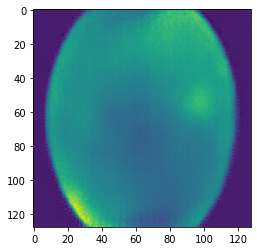

In [ ]:
plt.imshow(batch_rec1[1,:,:])

In [ ]:
slice_scores

[0.012163090519607067,
 0.009697746485471725,
 0.005191497039049864,
 0.002611537929624319,
 0.007952315732836723,
 0.005985564552247524,
 0.012930388562381268,
 0.021622350439429283,
 0.010297257453203201,
 0.005026031285524368,
 0.022304711863398552,
 0.013309127651154995,
 0.009648850187659264]

In [ ]:

pred = np.array(slice_scores).astype(float)

In [ ]:
pred

array([0.01216309, 0.00969775, 0.0051915 , 0.00261154, 0.00795232,
       0.00598556, 0.01293039, 0.02162235, 0.01029726, 0.00502603,
       0.02230471, 0.01330913, 0.00964885])

In [ ]:
#pred1 = np.clip(pred, a_max=1.0, a_min=0.0)
#pred1

In [ ]:
pred2=[pred>0.1]

In [ ]:
pred2

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False])]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from evalutils.io import ImageLoader


class DummyLoader(ImageLoader):
    @staticmethod
    def load_image(fname):
        return str(fname)


    @staticmethod
    def hash_image(image):
        return hash(image)


class airogs_algorithm(ClassificationAlgorithm):
    def __init__(self):
        super().__init__(
            validators=dict(
                input_image=(
                    UniqueImagesValidator(),
                    UniquePathIndicesValidator(),
                )
            ),
        )

        self._file_loaders = dict(input_image=DummyLoader())

        self.output_keys = ["multiple-referable-glaucoma-likelihoods", 
                            "multiple-referable-glaucoma-binary",
                            "multiple-ungradability-scores",
                            "multiple-ungradability-binary"]
    
    def load(self):
        for key, file_loader in self._file_loaders.items():
            fltr = (
                self._file_filters[key] if key in self._file_filters else None
            )
            self._cases[key] = self._load_cases(
                folder=Path("/content/drive/MyDrive/Irgos_challenege2022/airogs-example-algorithm-master/test/images/color-fundus/"),
                file_loader=file_loader,
                file_filter=fltr,
            )

        pass
    
    def combine_dicts(self, dicts):
        out = {}
        for d in dicts:
            for k, v in d.items():
                if k not in out:
                    out[k] = []
                out[k].append(v)
        return out
    
path="/content/drive/MyDrive/Irgos_challenege2022/airogs-example-algorithm-master/test/images/color-fundus/phase_1.tiff"
# Load and test the image(s) for this case
likelihood1=[]
rg_binary1=[]
ungradability_score1=[]
ungradability_binary1=[]
with tifffile.TiffFile(path) as stack:
  #predict11=[]
  #slice_scores=[]
  #predic00=[]
  for page in stack.pages:
    input_image_array = page.asarray()
    #print(input_image_array.shape)
    input_image_array= cv2.resize(input_image_array, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    input_image_array=((input_image_array - input_image_array.min()) / (input_image_array.max() - input_image_array.min()))
    print(input_image_array.shape)
    np_img=input_image_array
    torch_array=torch.from_numpy(np_img).unsqueeze(axis=0)
    torch_array=torch_array.permute(0, 3, 1, 2)
    torch_array=torch_array.float().to(device)
    ####### load pytorch model for prediction
    model=CNN()
    model=nn.DataParallel(model)
    model=model.to(device)
    pretrained=torch.load(path1)
    #model=nn.DataParallel(model)
    #model=model.to(device)
    model.load_state_dict(pretrained)
    with torch.no_grad():
      y_pred,_=model(torch_array)
      pc1= torch.softmax(y_pred, dim=1)
      pc1=pc1.squeeze(axis=0)
      predic0,predic1=pc1.detach().cpu().numpy()
      #p2=predic1
      #predict11.append(p2)
      #predic00.append(predic0)
      input_image_array1= cv2.resize(input_image_array, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
      input_image_array1=((input_image_array1 - input_image_array1.min()) / (input_image_array1.max() - input_image_array1.min()))
      print(input_image_array1.shape)
      np_img1=input_image_array1
      torch_array1=torch.from_numpy(np_img1).unsqueeze(axis=0)
      torch_array1=torch_array1.permute(0, 3, 1, 2)
      torch_array1=torch_array1.float().to(device)
      model1=model1.to(device)
      torch_array1=torch_array1.to(device)
      batch_rec = model1(torch_array1)
      loss = torch.mean(torch.pow(torch_array1 - batch_rec, 2), dim=(1, 2, 3))
      slice_scores += loss.cpu().tolist()
      #batch_rec1=batch_rec.squeeze(axis=0).detach().cpu().numpy()
      ###### output probabilties computed here
      likelihood=predic1
      rg_binary=(likelihood>0.5)
      un_gradable=predic0
      predb0=(un_gradable>0.5)
      ungradability_score=loss.cpu().numpy()*predb0
      ungradability_score=np.squeeze(ungradability_score)
      ungradability_binary=ungradability_score>0

      likelihood1.append(likelihood)
      rg_binary1.append(rg_binary)
      ungradability_score1.append(ungradability_score)
      ungradability_binary1.append(ungradability_binary)





(256, 256, 3)
(128, 128, 3)
(256, 256, 3)
(128, 128, 3)
(256, 256, 3)
(128, 128, 3)
(256, 256, 3)
(128, 128, 3)
(256, 256, 3)
(128, 128, 3)
(256, 256, 3)
(128, 128, 3)
(256, 256, 3)
(128, 128, 3)
(256, 256, 3)
(128, 128, 3)
(256, 256, 3)
(128, 128, 3)
(256, 256, 3)
(128, 128, 3)


In [ ]:
ungradability_binary1

[True, True, True, False, True, False, True, True, True, True]

In [ ]:
np.array(ungradability_score1)

0.0041809753

In [ ]:
rg_binary1

[False, False, False, True, False, True, False, False, False, False]

In [ ]:
likelihood1

[4.75302e-05,
 4.4433564e-05,
 5.8574675e-05,
 0.9977761,
 4.4186116e-05,
 0.9994217,
 4.3568405e-05,
 4.198575e-05,
 4.734292e-05,
 4.4428223e-05]

In [ ]:
np_array=np.array(predict11)
print(np_array)
predb=np_array>0.5
predb

[4.7530200e-05 4.4433564e-05 5.8574675e-05 9.9777609e-01 4.4186116e-05
 9.9942172e-01 4.3568405e-05 4.1985750e-05 4.7342921e-05 4.4428223e-05]


array([False, False, False,  True, False,  True, False, False, False,
       False])

In [ ]:
np_array0=np.array(predic00)
predb0=(np_array0>0.5)
predb0
#np_array0

array([ True,  True,  True, False,  True, False,  True,  True,  True,
        True])

In [ ]:
np_array0=np.array(predic00)
predb0=(np_array0>0.5)
d1=slice_scores*predb0
d2=d1>0

ValueError: ignored

In [ ]:
d2

array([ True,  True,  True, False,  True, False,  True,  True,  True,
        True])

In [ ]:
d1=slice_scores*predb0
d2=d1>0
d2

array([ True,  True,  True, False,  True, False,  True,  True,  True,
        True])